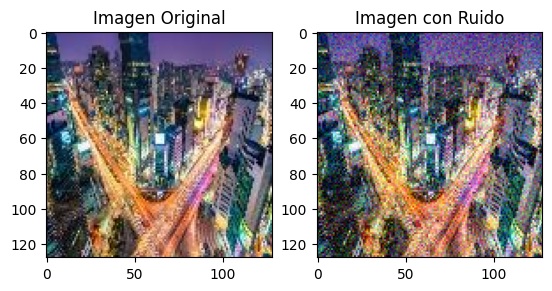

In [42]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Cargar imágenes del conjunto de entrenamiento
city_train_path = "processed_dataset/city/train-city"
forest_train_path = "processed_dataset/forest/train-forest"
img_size = (128, 128)

def load_images(folder):
    images = []
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Normalizar
        images.append(img)
    return np.array(images)

city_train = load_images(city_train_path)
forest_train = load_images(forest_train_path)


# Añadir Ruido Gaussiano
def add_gaussian_noise(image, mean=0, std=0.1):
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image


# Añadir Ruido a las Imágene
X_train = np.concatenate([city_train, forest_train])
X_train_noisy = np.array([add_gaussian_noise(img) for img in X_train])


# Ejemplo de Imagen Ruidosa
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X_train[0])
axes[0].set_title("Imagen Original")
axes[1].imshow(X_train_noisy[0])
axes[1].set_title("Imagen con Ruido")
plt.show()


In [43]:
from tensorflow.keras.models import Model
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
import tensorflow.keras.layers as layers

# Inicializar un run de W&B
wandb.init(project="autoencoder-denoising", config={
    "epochs": 200,
    "batch_size": 16,
    "img_size": img_size,
    "architecture": "autoencoder",
    "dataset": "city and forest"
})

# Configuración
config = wandb.config

# Crear el Autoencoder
input_img = layers.Input(shape=(*img_size, 3))
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Resumen del Modelo
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,507 (115.26 KB)

 Trainable params: 29,507 (115.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath='models/model-best.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
history = autoencoder.fit(
    X_train_noisy,
    X_train,
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    validation_split=0.1,
    callbacks=callbacks
)
wandb.finish()

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3486 - loss: 0.0892
Epoch 1: val_loss improved from inf to 0.07207, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.3497 - loss: 0.0891 - val_accuracy: 0.6041 - val_loss: 0.0721
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3460 - loss: 0.0702
Epoch 2: val_loss improved from 0.07207 to 0.04174, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3460 - loss: 0.0697 - val_accuracy: 0.5018 - val_loss: 0.0417
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3423 - loss: 0.0432
Epoch 3: val_loss improved from 0.04174 to 0.02972, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3431 - loss: 0.0430 - val_accuracy: 0.6166 - val_loss: 0.0297
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4263 - loss: 0.0339
Epoch 4: val_loss improved from 0.02972 to 0.02912, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4297 - loss: 0.0338 - val_accuracy: 0.4738 - val_loss: 0.0291
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5415 - loss: 0.0283
Epoch 5: val_loss improved from 0.02912 to 0.02498, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5431 - loss: 0.0283 - val_accuracy: 0.4182 - val_loss: 0.0250
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5934 - loss: 0.0265
Epoch 6: val_loss improved from 0.02498 to 0.02389, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5922 - loss: 0.0265 - val_accuracy: 0.6782 - val_loss: 0.0239
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5835 - loss: 0.0247
Epoch 7: val_loss improved from 0.02389 to 0.02204, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5846 - loss: 0.0247 - val_accuracy: 0.5225 - val_loss: 0.0220
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6422 - loss: 0.0238
Epoch 8: val_loss did not improve from 0.02204
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6414 - loss: 0.0237 - val_accuracy: 0.4536 - val_loss: 0.0227
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6282 - loss: 0.0223
Epoch 9: val_loss improved from 0.02204 to 0.02182, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6297 - loss: 0.0224 - val_accuracy: 0.6190 - val_loss: 0.0218
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6575 - loss: 0.0230
Epoch 10: val_loss improved from 0.02182 to 0.02027, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6581 - loss: 0.0229 - val_accuracy: 0.7084 - val_loss: 0.0203
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6820 - loss: 0.0203
Epoch 11: val_loss improved from 0.02027 to 0.01922, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6836 - loss: 0.0204 - val_accuracy: 0.7372 - val_loss: 0.0192
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7172 - loss: 0.0205
Epoch 12: val_loss did not improve from 0.01922
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7178 - loss: 0.0206 - val_accuracy: 0.7106 - val_loss: 0.0193
Epoch 13/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7300 - loss: 0.0220
Epoch 13: val_loss improved from 0.01922 to 0.01843, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7309 - loss: 0.0219 - val_accuracy: 0.7607 - val_loss: 0.0184
Epoch 14/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7660 - loss: 0.0189
Epoch 14: val_loss improved from 0.01843 to 0.01788, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7651 - loss: 0.0190 - val_accuracy: 0.8057 - val_loss: 0.0179
Epoch 15/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7753 - loss: 0.0202
Epoch 15: val_loss improved from 0.01788 to 0.01756, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7757 - loss: 0.0201 - val_accuracy: 0.8353 - val_loss: 0.0176
Epoch 16/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7945 - loss: 0.0184
Epoch 16: val_loss improved from 0.01756 to 0.01738, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7947 - loss: 0.0184 - val_accuracy: 0.8421 - val_loss: 0.0174
Epoch 17/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8079 - loss: 0.0185
Epoch 17: val_loss improved from 0.01738 to 0.01711, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8078 - loss: 0.0185 - val_accuracy: 0.8380 - val_loss: 0.0171
Epoch 18/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8098 - loss: 0.0177
Epoch 18: val_loss improved from 0.01711 to 0.01691, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8094 - loss: 0.0178 - val_accuracy: 0.8471 - val_loss: 0.0169
Epoch 19/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8032 - loss: 0.0187
Epoch 19: val_loss improved from 0.01691 to 0.01674, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8041 - loss: 0.0187 - val_accuracy: 0.8591 - val_loss: 0.0167
Epoch 20/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8294 - loss: 0.0172
Epoch 20: val_loss did not improve from 0.01674
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8281 - loss: 0.0173 - val_accuracy: 0.8590 - val_loss: 0.0170
Epoch 21/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8275 - loss: 0.0182
Epoch 21: val_loss improved from 0.01674 to 0.01646, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8264 - loss: 0.0182 - val_accuracy: 0.8568 - val_loss: 0.0165
Epoch 22/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8153 - loss: 0.0178
Epoch 22: val_loss improved from 0.01646 to 0.01632, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8158 - loss: 0.0178 - val_accuracy: 0.8626 - val_loss: 0.0163
Epoch 23/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8100 - loss: 0.0172
Epoch 23: val_loss improved from 0.01632 to 0.01620, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8113 - loss: 0.0172 - val_accuracy: 0.8625 - val_loss: 0.0162
Epoch 24/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8265 - loss: 0.0164
Epoch 24: val_loss improved from 0.01620 to 0.01610, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8260 - loss: 0.0165 - val_accuracy: 0.8611 - val_loss: 0.0161
Epoch 25/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8164 - loss: 0.0174
Epoch 25: val_loss did not improve from 0.01610
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8170 - loss: 0.0174 - val_accuracy: 0.8582 - val_loss: 0.0162
Epoch 26/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8256 - loss: 0.0177
Epoch 26: val_loss did not improve from 0.01610
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8256 - loss: 0.0177 - val_accuracy: 0.8633 - val_loss: 0.0163
Epoch 27/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8195 - loss: 0.0163
Epoch 27: val_loss improved from 0.01610 to 0.01580, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8198 - loss: 0.0164 - val_accuracy: 0.8655 - val_loss: 0.0158
Epoch 28/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8192 - loss: 0.0177
Epoch 28: val_loss improved from 0.01580 to 0.01571, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8193 - loss: 0.0177 - val_accuracy: 0.8664 - val_loss: 0.0157
Epoch 29/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8230 - loss: 0.0167
Epoch 29: val_loss improved from 0.01571 to 0.01568, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8228 - loss: 0.0167 - val_accuracy: 0.8647 - val_loss: 0.0157
Epoch 30/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8229 - loss: 0.0165
Epoch 30: val_loss improved from 0.01568 to 0.01551, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8228 - loss: 0.0165 - val_accuracy: 0.8689 - val_loss: 0.0155
Epoch 31/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8342 - loss: 0.0175
Epoch 31: val_loss did not improve from 0.01551
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8340 - loss: 0.0175 - val_accuracy: 0.8658 - val_loss: 0.0156
Epoch 32/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8334 - loss: 0.0169
Epoch 32: val_loss improved from 0.01551 to 0.01538, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8333 - loss: 0.0168 - val_accuracy: 0.8664 - val_loss: 0.0154
Epoch 33/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.0174
Epoch 33: val_loss improved from 0.01538 to 0.01533, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8389 - loss: 0.0173 - val_accuracy: 0.8697 - val_loss: 0.0153
Epoch 34/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8346 - loss: 0.0165
Epoch 34: val_loss improved from 0.01533 to 0.01524, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8344 - loss: 0.0165 - val_accuracy: 0.8706 - val_loss: 0.0152
Epoch 35/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8340 - loss: 0.0166
Epoch 35: val_loss did not improve from 0.01524
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8337 - loss: 0.0166 - val_accuracy: 0.8717 - val_loss: 0.0154
Epoch 36/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8255 - loss: 0.0163
Epoch 36: val_loss did not improve from 0.01524
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8260 - loss: 0.0163 - val_accuracy: 0.8663 - val_loss: 0.0153
Epoch 37/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8281 - loss: 0.0157
Epoch 37: val_loss did not improve from 0.01524
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8285 - loss: 0.0157 - val_accuracy: 0.8722 - val_loss: 0.0153
Epoch 38/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8234 - loss: 0.0167
Epoch 38: val_loss improved from 0.01524 to 0.01512, saving 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8244 - loss: 0.0167 - val_accuracy: 0.8695 - val_loss: 0.0151
Epoch 39/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8362 - loss: 0.0165
Epoch 39: val_loss improved from 0.01512 to 0.01500, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8360 - loss: 0.0165 - val_accuracy: 0.8700 - val_loss: 0.0150
Epoch 40/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8372 - loss: 0.0159
Epoch 40: val_loss did not improve from 0.01500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8369 - loss: 0.0160 - val_accuracy: 0.8704 - val_loss: 0.0150
Epoch 41/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8327 - loss: 0.0159
Epoch 41: val_loss did not improve from 0.01500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8329 - loss: 0.0159 - val_accuracy: 0.8736 - val_loss: 0.0152
Epoch 42/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8248 - loss: 0.0164
Epoch 42: val_loss did not improve from 0.01500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8255 - loss: 0.0164 - val_accuracy: 0.8681 - val_loss: 0.0150
Epoch 43/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8381 - loss: 0.0156
Epoch 43: val_loss improved from 0.01500 to 0.01487, saving 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8379 - loss: 0.0156 - val_accuracy: 0.8692 - val_loss: 0.0149
Epoch 44/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8319 - loss: 0.0157
Epoch 44: val_loss did not improve from 0.01487
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8323 - loss: 0.0157 - val_accuracy: 0.8682 - val_loss: 0.0149
Epoch 45/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8339 - loss: 0.0160
Epoch 45: val_loss did not improve from 0.01487
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8341 - loss: 0.0160 - val_accuracy: 0.8729 - val_loss: 0.0150
Epoch 46/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8432 - loss: 0.0148
Epoch 46: val_loss improved from 0.01487 to 0.01480, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8426 - loss: 0.0149 - val_accuracy: 0.8725 - val_loss: 0.0148
Epoch 47/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8269 - loss: 0.0159
Epoch 47: val_loss did not improve from 0.01480
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8279 - loss: 0.0159 - val_accuracy: 0.8731 - val_loss: 0.0149
Epoch 48/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8303 - loss: 0.0162
Epoch 48: val_loss improved from 0.01480 to 0.01469, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8306 - loss: 0.0161 - val_accuracy: 0.8685 - val_loss: 0.0147
Epoch 49/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8194 - loss: 0.0158
Epoch 49: val_loss did not improve from 0.01469
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8209 - loss: 0.0158 - val_accuracy: 0.8613 - val_loss: 0.0148
Epoch 50/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8395 - loss: 0.0150
Epoch 50: val_loss improved from 0.01469 to 0.01467, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8390 - loss: 0.0151 - val_accuracy: 0.8757 - val_loss: 0.0147
Epoch 51/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8506 - loss: 0.0155
Epoch 51: val_loss improved from 0.01467 to 0.01460, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8492 - loss: 0.0155 - val_accuracy: 0.8754 - val_loss: 0.0146
Epoch 52/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8488 - loss: 0.0155
Epoch 52: val_loss did not improve from 0.01460
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8477 - loss: 0.0155 - val_accuracy: 0.8720 - val_loss: 0.0146
Epoch 53/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8408 - loss: 0.0158
Epoch 53: val_loss improved from 0.01460 to 0.01459, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8402 - loss: 0.0158 - val_accuracy: 0.8721 - val_loss: 0.0146
Epoch 54/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8410 - loss: 0.0147
Epoch 54: val_loss improved from 0.01459 to 0.01457, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8405 - loss: 0.0148 - val_accuracy: 0.8716 - val_loss: 0.0146
Epoch 55/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8287 - loss: 0.0162
Epoch 55: val_loss did not improve from 0.01457
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8298 - loss: 0.0161 - val_accuracy: 0.8636 - val_loss: 0.0146
Epoch 56/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8399 - loss: 0.0154
Epoch 56: val_loss improved from 0.01457 to 0.01451, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8395 - loss: 0.0154 - val_accuracy: 0.8755 - val_loss: 0.0145
Epoch 57/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8506 - loss: 0.0147
Epoch 57: val_loss improved from 0.01451 to 0.01448, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8492 - loss: 0.0148 - val_accuracy: 0.8663 - val_loss: 0.0145
Epoch 58/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8448 - loss: 0.0153
Epoch 58: val_loss improved from 0.01448 to 0.01441, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8444 - loss: 0.0153 - val_accuracy: 0.8729 - val_loss: 0.0144
Epoch 59/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8343 - loss: 0.0154
Epoch 59: val_loss did not improve from 0.01441
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8349 - loss: 0.0154 - val_accuracy: 0.8774 - val_loss: 0.0145
Epoch 60/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8321 - loss: 0.0154
Epoch 60: val_loss did not improve from 0.01441
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8331 - loss: 0.0154 - val_accuracy: 0.8694 - val_loss: 0.0144
Epoch 61/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8462 - loss: 0.0146
Epoch 61: val_loss did not improve from 0.01441
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8457 - loss: 0.0147 - val_accuracy: 0.8736 - val_loss: 0.0146
Epoch 62/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8418 - loss: 0.0153
Epoch 62: val_loss did not improve from 0.01441
9/9 ━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8359 - loss: 0.0148 - val_accuracy: 0.8671 - val_loss: 0.0144
Epoch 64/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8386 - loss: 0.0157
Epoch 64: val_loss improved from 0.01438 to 0.01428, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8385 - loss: 0.0157 - val_accuracy: 0.8753 - val_loss: 0.0143
Epoch 65/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8393 - loss: 0.0149
Epoch 65: val_loss improved from 0.01428 to 0.01425, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8397 - loss: 0.0149 - val_accuracy: 0.8737 - val_loss: 0.0142
Epoch 66/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8495 - loss: 0.0156
Epoch 66: val_loss did not improve from 0.01425
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8488 - loss: 0.0155 - val_accuracy: 0.8777 - val_loss: 0.0144
Epoch 67/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8360 - loss: 0.0147
Epoch 67: val_loss did not improve from 0.01425
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8364 - loss: 0.0148 - val_accuracy: 0.8740 - val_loss: 0.0143
Epoch 68/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8448 - loss: 0.0160
Epoch 68: val_loss did not improve from 0.01425
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8444 - loss: 0.0159 - val_accuracy: 0.8725 - val_loss: 0.0145
Epoch 69/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8341 - loss: 0.0156
Epoch 69: val_loss improved from 0.01425 to 0.01420, saving 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8344 - loss: 0.0155 - val_accuracy: 0.8705 - val_loss: 0.0142
Epoch 70/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8394 - loss: 0.0145
Epoch 70: val_loss did not improve from 0.01420
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8393 - loss: 0.0145 - val_accuracy: 0.8779 - val_loss: 0.0142
Epoch 71/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8370 - loss: 0.0155
Epoch 71: val_loss improved from 0.01420 to 0.01413, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8372 - loss: 0.0154 - val_accuracy: 0.8738 - val_loss: 0.0141
Epoch 72/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8492 - loss: 0.0149
Epoch 72: val_loss did not improve from 0.01413
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8483 - loss: 0.0149 - val_accuracy: 0.8756 - val_loss: 0.0143
Epoch 73/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8423 - loss: 0.0150
Epoch 73: val_loss improved from 0.01413 to 0.01411, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8426 - loss: 0.0150 - val_accuracy: 0.8748 - val_loss: 0.0141
Epoch 74/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8397 - loss: 0.0146
Epoch 74: val_loss improved from 0.01411 to 0.01408, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8401 - loss: 0.0147 - val_accuracy: 0.8768 - val_loss: 0.0141
Epoch 75/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8442 - loss: 0.0149
Epoch 75: val_loss did not improve from 0.01408
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8443 - loss: 0.0149 - val_accuracy: 0.8743 - val_loss: 0.0141
Epoch 76/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8280 - loss: 0.0155
Epoch 76: val_loss improved from 0.01408 to 0.01407, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8295 - loss: 0.0154 - val_accuracy: 0.8782 - val_loss: 0.0141
Epoch 77/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8360 - loss: 0.0145
Epoch 77: val_loss did not improve from 0.01407
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8366 - loss: 0.0145 - val_accuracy: 0.8735 - val_loss: 0.0141
Epoch 78/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8477 - loss: 0.0146
Epoch 78: val_loss improved from 0.01407 to 0.01402, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8469 - loss: 0.0146 - val_accuracy: 0.8774 - val_loss: 0.0140
Epoch 79/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8433 - loss: 0.0148
Epoch 79: val_loss improved from 0.01402 to 0.01397, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8432 - loss: 0.0148 - val_accuracy: 0.8729 - val_loss: 0.0140
Epoch 80/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8412 - loss: 0.0148
Epoch 80: val_loss improved from 0.01397 to 0.01396, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8414 - loss: 0.0148 - val_accuracy: 0.8797 - val_loss: 0.0140
Epoch 81/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8393 - loss: 0.0147
Epoch 81: val_loss improved from 0.01396 to 0.01393, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8399 - loss: 0.0147 - val_accuracy: 0.8721 - val_loss: 0.0139
Epoch 82/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8439 - loss: 0.0153
Epoch 82: val_loss improved from 0.01393 to 0.01392, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8437 - loss: 0.0152 - val_accuracy: 0.8718 - val_loss: 0.0139
Epoch 83/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8309 - loss: 0.0147
Epoch 83: val_loss improved from 0.01392 to 0.01388, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8320 - loss: 0.0147 - val_accuracy: 0.8748 - val_loss: 0.0139
Epoch 84/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8448 - loss: 0.0143
Epoch 84: val_loss improved from 0.01388 to 0.01385, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8446 - loss: 0.0143 - val_accuracy: 0.8755 - val_loss: 0.0138
Epoch 85/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8400 - loss: 0.0152
Epoch 85: val_loss did not improve from 0.01385
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8402 - loss: 0.0151 - val_accuracy: 0.8769 - val_loss: 0.0139
Epoch 86/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8463 - loss: 0.0151
Epoch 86: val_loss did not improve from 0.01385
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8458 - loss: 0.0151 - val_accuracy: 0.8726 - val_loss: 0.0139
Epoch 87/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8298 - loss: 0.0147
Epoch 87: val_loss did not improve from 0.01385
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8312 - loss: 0.0147 - val_accuracy: 0.8796 - val_loss: 0.0139
Epoch 88/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8427 - loss: 0.0148
Epoch 88: val_loss did not improve from 0.01385
9/9 ━━━━━━━━

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8485 - loss: 0.0143 - val_accuracy: 0.8712 - val_loss: 0.0138
Epoch 90/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8432 - loss: 0.0148
Epoch 90: val_loss did not improve from 0.01382
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8433 - loss: 0.0148 - val_accuracy: 0.8710 - val_loss: 0.0140
Epoch 91/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8496 - loss: 0.0146
Epoch 91: val_loss improved from 0.01382 to 0.01376, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8489 - loss: 0.0146 - val_accuracy: 0.8753 - val_loss: 0.0138
Epoch 92/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8388 - loss: 0.0149
Epoch 92: val_loss improved from 0.01376 to 0.01374, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8392 - loss: 0.0149 - val_accuracy: 0.8753 - val_loss: 0.0137
Epoch 93/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8598 - loss: 0.0139
Epoch 93: val_loss improved from 0.01374 to 0.01370, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8583 - loss: 0.0139 - val_accuracy: 0.8771 - val_loss: 0.0137
Epoch 94/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8458 - loss: 0.0149
Epoch 94: val_loss did not improve from 0.01370
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8458 - loss: 0.0149 - val_accuracy: 0.8728 - val_loss: 0.0138
Epoch 95/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8540 - loss: 0.0144
Epoch 95: val_loss improved from 0.01370 to 0.01369, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8531 - loss: 0.0144 - val_accuracy: 0.8752 - val_loss: 0.0137
Epoch 96/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8387 - loss: 0.0142
Epoch 96: val_loss did not improve from 0.01369
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8391 - loss: 0.0142 - val_accuracy: 0.8755 - val_loss: 0.0137
Epoch 97/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8524 - loss: 0.0144
Epoch 97: val_loss did not improve from 0.01369
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8518 - loss: 0.0144 - val_accuracy: 0.8711 - val_loss: 0.0137
Epoch 98/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8500 - loss: 0.0139
Epoch 98: val_loss improved from 0.01369 to 0.01366, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8495 - loss: 0.0139 - val_accuracy: 0.8768 - val_loss: 0.0137
Epoch 99/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8403 - loss: 0.0152
Epoch 99: val_loss improved from 0.01366 to 0.01361, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8408 - loss: 0.0152 - val_accuracy: 0.8771 - val_loss: 0.0136
Epoch 100/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8442 - loss: 0.0148
Epoch 100: val_loss did not improve from 0.01361
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8444 - loss: 0.0148 - val_accuracy: 0.8734 - val_loss: 0.0136
Epoch 101/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8425 - loss: 0.0143
Epoch 101: val_loss did not improve from 0.01361
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8428 - loss: 0.0143 - val_accuracy: 0.8732 - val_loss: 0.0139
Epoch 102/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8402 - loss: 0.0140
Epoch 102: val_loss improved from 0.01361 to 0.01358, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8407 - loss: 0.0141 - val_accuracy: 0.8778 - val_loss: 0.0136
Epoch 103/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8503 - loss: 0.0144
Epoch 103: val_loss did not improve from 0.01358
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8497 - loss: 0.0144 - val_accuracy: 0.8743 - val_loss: 0.0136
Epoch 104/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8458 - loss: 0.0149
Epoch 104: val_loss did not improve from 0.01358
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8456 - loss: 0.0149 - val_accuracy: 0.8753 - val_loss: 0.0137
Epoch 105/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8469 - loss: 0.0140
Epoch 105: val_loss did not improve from 0.01358
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8465 - loss: 0.0140 - val_accuracy: 0.8749 - val_loss: 0.0136
Epoch 106/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8382 - loss: 0.0142
Epoch 106: val_loss improved from 0.01358 to 0.01354,

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8387 - loss: 0.0142 - val_accuracy: 0.8751 - val_loss: 0.0135
Epoch 107/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8366 - loss: 0.0146
Epoch 107: val_loss improved from 0.01354 to 0.01350, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8375 - loss: 0.0145 - val_accuracy: 0.8762 - val_loss: 0.0135
Epoch 108/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8492 - loss: 0.0146
Epoch 108: val_loss improved from 0.01350 to 0.01348, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8489 - loss: 0.0145 - val_accuracy: 0.8748 - val_loss: 0.0135
Epoch 109/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8484 - loss: 0.0142
Epoch 109: val_loss did not improve from 0.01348
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8481 - loss: 0.0142 - val_accuracy: 0.8750 - val_loss: 0.0137
Epoch 110/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8440 - loss: 0.0144
Epoch 110: val_loss improved from 0.01348 to 0.01345, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8442 - loss: 0.0144 - val_accuracy: 0.8751 - val_loss: 0.0135
Epoch 111/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8532 - loss: 0.0144
Epoch 111: val_loss improved from 0.01345 to 0.01345, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8525 - loss: 0.0143 - val_accuracy: 0.8731 - val_loss: 0.0134
Epoch 112/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8396 - loss: 0.0148
Epoch 112: val_loss improved from 0.01345 to 0.01344, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8402 - loss: 0.0148 - val_accuracy: 0.8724 - val_loss: 0.0134
Epoch 113/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8404 - loss: 0.0142
Epoch 113: val_loss did not improve from 0.01344
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8410 - loss: 0.0142 - val_accuracy: 0.8743 - val_loss: 0.0136
Epoch 114/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8396 - loss: 0.0145
Epoch 114: val_loss did not improve from 0.01344
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8401 - loss: 0.0145 - val_accuracy: 0.8744 - val_loss: 0.0138
Epoch 115/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8480 - loss: 0.0142
Epoch 115: val_loss improved from 0.01344 to 0.01341, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8477 - loss: 0.0142 - val_accuracy: 0.8731 - val_loss: 0.0134
Epoch 116/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8486 - loss: 0.0145
Epoch 116: val_loss improved from 0.01341 to 0.01340, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8481 - loss: 0.0145 - val_accuracy: 0.8767 - val_loss: 0.0134
Epoch 117/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8506 - loss: 0.0142
Epoch 117: val_loss did not improve from 0.01340
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8503 - loss: 0.0141 - val_accuracy: 0.8764 - val_loss: 0.0134
Epoch 118/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8441 - loss: 0.0138
Epoch 118: val_loss improved from 0.01340 to 0.01334, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8444 - loss: 0.0138 - val_accuracy: 0.8777 - val_loss: 0.0133
Epoch 119/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8449 - loss: 0.0147
Epoch 119: val_loss improved from 0.01334 to 0.01333, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8450 - loss: 0.0146 - val_accuracy: 0.8772 - val_loss: 0.0133
Epoch 120/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8477 - loss: 0.0133
Epoch 120: val_loss did not improve from 0.01333
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8475 - loss: 0.0134 - val_accuracy: 0.8755 - val_loss: 0.0134
Epoch 121/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8485 - loss: 0.0135
Epoch 121: val_loss did not improve from 0.01333
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8479 - loss: 0.0136 - val_accuracy: 0.8783 - val_loss: 0.0135
Epoch 122/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8467 - loss: 0.0143
Epoch 122: val_loss did not improve from 0.01333
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8467 - loss: 0.0143 - val_accuracy: 0.8736 - val_loss: 0.0136
Epoch 123/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8408 - loss: 0.0139
Epoch 123: val_loss did not improve from 0.01333
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8447 - loss: 0.0148 - val_accuracy: 0.8777 - val_loss: 0.0133
Epoch 125/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8460 - loss: 0.0141
Epoch 125: val_loss improved from 0.01327 to 0.01326, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8460 - loss: 0.0140 - val_accuracy: 0.8764 - val_loss: 0.0133
Epoch 126/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8356 - loss: 0.0144
Epoch 126: val_loss improved from 0.01326 to 0.01325, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8365 - loss: 0.0143 - val_accuracy: 0.8748 - val_loss: 0.0133
Epoch 127/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8500 - loss: 0.0143
Epoch 127: val_loss improved from 0.01325 to 0.01322, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8497 - loss: 0.0143 - val_accuracy: 0.8801 - val_loss: 0.0132
Epoch 128/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8614 - loss: 0.0133
Epoch 128: val_loss improved from 0.01322 to 0.01321, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8598 - loss: 0.0134 - val_accuracy: 0.8723 - val_loss: 0.0132
Epoch 129/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8349 - loss: 0.0135
Epoch 129: val_loss did not improve from 0.01321
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8360 - loss: 0.0135 - val_accuracy: 0.8775 - val_loss: 0.0132
Epoch 130/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8432 - loss: 0.0142
Epoch 130: val_loss improved from 0.01321 to 0.01316, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8437 - loss: 0.0142 - val_accuracy: 0.8783 - val_loss: 0.0132
Epoch 131/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8518 - loss: 0.0135
Epoch 131: val_loss did not improve from 0.01316
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8514 - loss: 0.0135 - val_accuracy: 0.8771 - val_loss: 0.0132
Epoch 132/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8556 - loss: 0.0132
Epoch 132: val_loss did not improve from 0.01316
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8547 - loss: 0.0133 - val_accuracy: 0.8718 - val_loss: 0.0132
Epoch 133/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8424 - loss: 0.0135
Epoch 133: val_loss improved from 0.01316 to 0.01313, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8428 - loss: 0.0136 - val_accuracy: 0.8769 - val_loss: 0.0131
Epoch 134/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8491 - loss: 0.0139
Epoch 134: val_loss did not improve from 0.01313
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8487 - loss: 0.0139 - val_accuracy: 0.8785 - val_loss: 0.0132
Epoch 135/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8480 - loss: 0.0138
Epoch 135: val_loss did not improve from 0.01313
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8476 - loss: 0.0138 - val_accuracy: 0.8669 - val_loss: 0.0135
Epoch 136/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8327 - loss: 0.0136
Epoch 136: val_loss did not improve from 0.01313
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8339 - loss: 0.0136 - val_accuracy: 0.8796 - val_loss: 0.0135
Epoch 137/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8307 - loss: 0.0140
Epoch 137: val_loss did not improve from 0.01313
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.8400 - loss: 0.0137 - val_accuracy: 0.8766 - val_loss: 0.0131
Epoch 139/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8451 - loss: 0.0143
Epoch 139: val_loss did not improve from 0.01309
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8451 - loss: 0.0142 - val_accuracy: 0.8788 - val_loss: 0.0133
Epoch 140/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8524 - loss: 0.0138
Epoch 140: val_loss did not improve from 0.01309
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8519 - loss: 0.0138 - val_accuracy: 0.8771 - val_loss: 0.0132
Epoch 141/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8340 - loss: 0.0135
Epoch 141: val_loss improved from 0.01309 to 0.01306, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8353 - loss: 0.0135 - val_accuracy: 0.8794 - val_loss: 0.0131
Epoch 142/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8492 - loss: 0.0138
Epoch 142: val_loss improved from 0.01306 to 0.01302, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8490 - loss: 0.0138 - val_accuracy: 0.8790 - val_loss: 0.0130
Epoch 143/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8453 - loss: 0.0137
Epoch 143: val_loss did not improve from 0.01302
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8456 - loss: 0.0137 - val_accuracy: 0.8776 - val_loss: 0.0131
Epoch 144/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8469 - loss: 0.0132
Epoch 144: val_loss did not improve from 0.01302
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8470 - loss: 0.0132 - val_accuracy: 0.8760 - val_loss: 0.0130
Epoch 145/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8532 - loss: 0.0136
Epoch 145: val_loss did not improve from 0.01302
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8526 - loss: 0.0136 - val_accuracy: 0.8717 - val_loss: 0.0130
Epoch 146/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8466 - loss: 0.0139
Epoch 146: val_loss improved from 0.01302 to 0.01299,

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8465 - loss: 0.0138 - val_accuracy: 0.8755 - val_loss: 0.0130
Epoch 147/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8571 - loss: 0.0141
Epoch 147: val_loss improved from 0.01299 to 0.01297, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8559 - loss: 0.0141 - val_accuracy: 0.8799 - val_loss: 0.0130
Epoch 148/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8453 - loss: 0.0142
Epoch 148: val_loss did not improve from 0.01297
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8455 - loss: 0.0141 - val_accuracy: 0.8783 - val_loss: 0.0130
Epoch 149/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8508 - loss: 0.0134
Epoch 149: val_loss improved from 0.01297 to 0.01295, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8507 - loss: 0.0134 - val_accuracy: 0.8772 - val_loss: 0.0130
Epoch 150/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8550 - loss: 0.0131
Epoch 150: val_loss improved from 0.01295 to 0.01294, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8544 - loss: 0.0131 - val_accuracy: 0.8785 - val_loss: 0.0129
Epoch 151/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8461 - loss: 0.0135
Epoch 151: val_loss did not improve from 0.01294
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8461 - loss: 0.0135 - val_accuracy: 0.8780 - val_loss: 0.0130
Epoch 152/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8329 - loss: 0.0139
Epoch 152: val_loss did not improve from 0.01294
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8344 - loss: 0.0138 - val_accuracy: 0.8740 - val_loss: 0.0131
Epoch 153/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8594 - loss: 0.0139
Epoch 153: val_loss did not improve from 0.01294
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8582 - loss: 0.0139 - val_accuracy: 0.8773 - val_loss: 0.0131
Epoch 154/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8604 - loss: 0.0137
Epoch 154: val_loss improved from 0.01294 to 0.01290,

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8593 - loss: 0.0137 - val_accuracy: 0.8774 - val_loss: 0.0129
Epoch 155/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8610 - loss: 0.0129
Epoch 155: val_loss improved from 0.01290 to 0.01289, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8597 - loss: 0.0130 - val_accuracy: 0.8811 - val_loss: 0.0129
Epoch 156/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8548 - loss: 0.0126
Epoch 156: val_loss did not improve from 0.01289
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8540 - loss: 0.0126 - val_accuracy: 0.8806 - val_loss: 0.0131
Epoch 157/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8414 - loss: 0.0144
Epoch 157: val_loss did not improve from 0.01289
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8420 - loss: 0.0144 - val_accuracy: 0.8766 - val_loss: 0.0132
Epoch 158/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8362 - loss: 0.0141
Epoch 158: val_loss did not improve from 0.01289
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8374 - loss: 0.0141 - val_accuracy: 0.8784 - val_loss: 0.0132
Epoch 159/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8593 - loss: 0.0143
Epoch 159: val_loss did not improve from 0.01289
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8544 - loss: 0.0133 - val_accuracy: 0.8767 - val_loss: 0.0128
Epoch 162/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8519 - loss: 0.0134
Epoch 162: val_loss improved from 0.01284 to 0.01283, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8515 - loss: 0.0134 - val_accuracy: 0.8768 - val_loss: 0.0128
Epoch 163/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8600 - loss: 0.0130
Epoch 163: val_loss improved from 0.01283 to 0.01281, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8588 - loss: 0.0130 - val_accuracy: 0.8785 - val_loss: 0.0128
Epoch 164/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8468 - loss: 0.0135
Epoch 164: val_loss did not improve from 0.01281
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8470 - loss: 0.0135 - val_accuracy: 0.8780 - val_loss: 0.0128
Epoch 165/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8497 - loss: 0.0135
Epoch 165: val_loss did not improve from 0.01281
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8496 - loss: 0.0135 - val_accuracy: 0.8763 - val_loss: 0.0131
Epoch 166/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8352 - loss: 0.0134
Epoch 166: val_loss improved from 0.01281 to 0.01279, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8364 - loss: 0.0134 - val_accuracy: 0.8750 - val_loss: 0.0128
Epoch 167/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8328 - loss: 0.0135
Epoch 167: val_loss did not improve from 0.01279
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8338 - loss: 0.0135 - val_accuracy: 0.8783 - val_loss: 0.0128
Epoch 168/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8492 - loss: 0.0124
Epoch 168: val_loss improved from 0.01279 to 0.01275, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8491 - loss: 0.0125 - val_accuracy: 0.8792 - val_loss: 0.0128
Epoch 169/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8540 - loss: 0.0129
Epoch 169: val_loss did not improve from 0.01275
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8532 - loss: 0.0130 - val_accuracy: 0.8785 - val_loss: 0.0129
Epoch 170/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8469 - loss: 0.0132
Epoch 170: val_loss did not improve from 0.01275
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8472 - loss: 0.0132 - val_accuracy: 0.8817 - val_loss: 0.0129
Epoch 171/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8425 - loss: 0.0133
Epoch 171: val_loss did not improve from 0.01275
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8427 - loss: 0.0133 - val_accuracy: 0.8740 - val_loss: 0.0130
Epoch 172/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8459 - loss: 0.0136
Epoch 172: val_loss did not improve from 0.01275
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8476 - loss: 0.0130 - val_accuracy: 0.8777 - val_loss: 0.0127
Epoch 174/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8477 - loss: 0.0132
Epoch 174: val_loss improved from 0.01271 to 0.01269, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8477 - loss: 0.0132 - val_accuracy: 0.8815 - val_loss: 0.0127
Epoch 175/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8526 - loss: 0.0133
Epoch 175: val_loss improved from 0.01269 to 0.01266, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8523 - loss: 0.0133 - val_accuracy: 0.8778 - val_loss: 0.0127
Epoch 176/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8575 - loss: 0.0130
Epoch 176: val_loss improved from 0.01266 to 0.01266, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8566 - loss: 0.0130 - val_accuracy: 0.8787 - val_loss: 0.0127
Epoch 177/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8546 - loss: 0.0135
Epoch 177: val_loss did not improve from 0.01266
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8538 - loss: 0.0135 - val_accuracy: 0.8776 - val_loss: 0.0128
Epoch 178/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8404 - loss: 0.0136
Epoch 178: val_loss did not improve from 0.01266
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8409 - loss: 0.0136 - val_accuracy: 0.8737 - val_loss: 0.0127
Epoch 179/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8515 - loss: 0.0129
Epoch 179: val_loss did not improve from 0.01266
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8512 - loss: 0.0129 - val_accuracy: 0.8749 - val_loss: 0.0127
Epoch 180/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8590 - loss: 0.0135
Epoch 180: val_loss improved from 0.01266 to 0.01263,

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8578 - loss: 0.0134 - val_accuracy: 0.8799 - val_loss: 0.0126
Epoch 181/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8568 - loss: 0.0130
Epoch 181: val_loss improved from 0.01263 to 0.01258, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8560 - loss: 0.0130 - val_accuracy: 0.8794 - val_loss: 0.0126
Epoch 182/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8487 - loss: 0.0144
Epoch 182: val_loss improved from 0.01258 to 0.01257, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8487 - loss: 0.0143 - val_accuracy: 0.8788 - val_loss: 0.0126
Epoch 183/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8466 - loss: 0.0130
Epoch 183: val_loss did not improve from 0.01257
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8467 - loss: 0.0130 - val_accuracy: 0.8749 - val_loss: 0.0127
Epoch 184/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8472 - loss: 0.0138
Epoch 184: val_loss did not improve from 0.01257
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8474 - loss: 0.0137 - val_accuracy: 0.8762 - val_loss: 0.0131
Epoch 185/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8577 - loss: 0.0135
Epoch 185: val_loss did not improve from 0.01257
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8567 - loss: 0.0135 - val_accuracy: 0.8754 - val_loss: 0.0126
Epoch 186/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8484 - loss: 0.0130
Epoch 186: val_loss did not improve from 0.01257
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8419 - loss: 0.0136 - val_accuracy: 0.8793 - val_loss: 0.0126
Epoch 188/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8379 - loss: 0.0130
Epoch 188: val_loss improved from 0.01256 to 0.01248, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8387 - loss: 0.0130 - val_accuracy: 0.8781 - val_loss: 0.0125
Epoch 189/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8553 - loss: 0.0123
Epoch 189: val_loss did not improve from 0.01248
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8546 - loss: 0.0124 - val_accuracy: 0.8776 - val_loss: 0.0126
Epoch 190/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8499 - loss: 0.0129
Epoch 190: val_loss did not improve from 0.01248
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8497 - loss: 0.0129 - val_accuracy: 0.8784 - val_loss: 0.0126
Epoch 191/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8485 - loss: 0.0132
Epoch 191: val_loss did not improve from 0.01248
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8482 - loss: 0.0132 - val_accuracy: 0.8780 - val_loss: 0.0132
Epoch 192/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8453 - loss: 0.0133
Epoch 192: val_loss did not improve from 0.01248
9/9 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8523 - loss: 0.0127 - val_accuracy: 0.8776 - val_loss: 0.0124
Epoch 194/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8546 - loss: 0.0127
Epoch 194: val_loss did not improve from 0.01242
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8538 - loss: 0.0127 - val_accuracy: 0.8773 - val_loss: 0.0124
Epoch 195/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8511 - loss: 0.0136
Epoch 195: val_loss improved from 0.01242 to 0.01238, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8508 - loss: 0.0135 - val_accuracy: 0.8758 - val_loss: 0.0124
Epoch 196/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8485 - loss: 0.0128
Epoch 196: val_loss improved from 0.01238 to 0.01237, saving model to models/model-best.h5


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8485 - loss: 0.0128 - val_accuracy: 0.8703 - val_loss: 0.0124
Epoch 197/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8437 - loss: 0.0135
Epoch 197: val_loss did not improve from 0.01237
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8441 - loss: 0.0134 - val_accuracy: 0.8722 - val_loss: 0.0124
Epoch 198/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8477 - loss: 0.0143
Epoch 198: val_loss did not improve from 0.01237
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8473 - loss: 0.0143 - val_accuracy: 0.8646 - val_loss: 0.0129
Epoch 199/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8459 - loss: 0.0142
Epoch 199: val_loss did not improve from 0.01237
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8454 - loss: 0.0142 - val_accuracy: 0.8626 - val_loss: 0.0128
Epoch 200/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8303 - loss: 0.0136
Epoch 200: val_loss did not improve from 0.01237
9/9 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


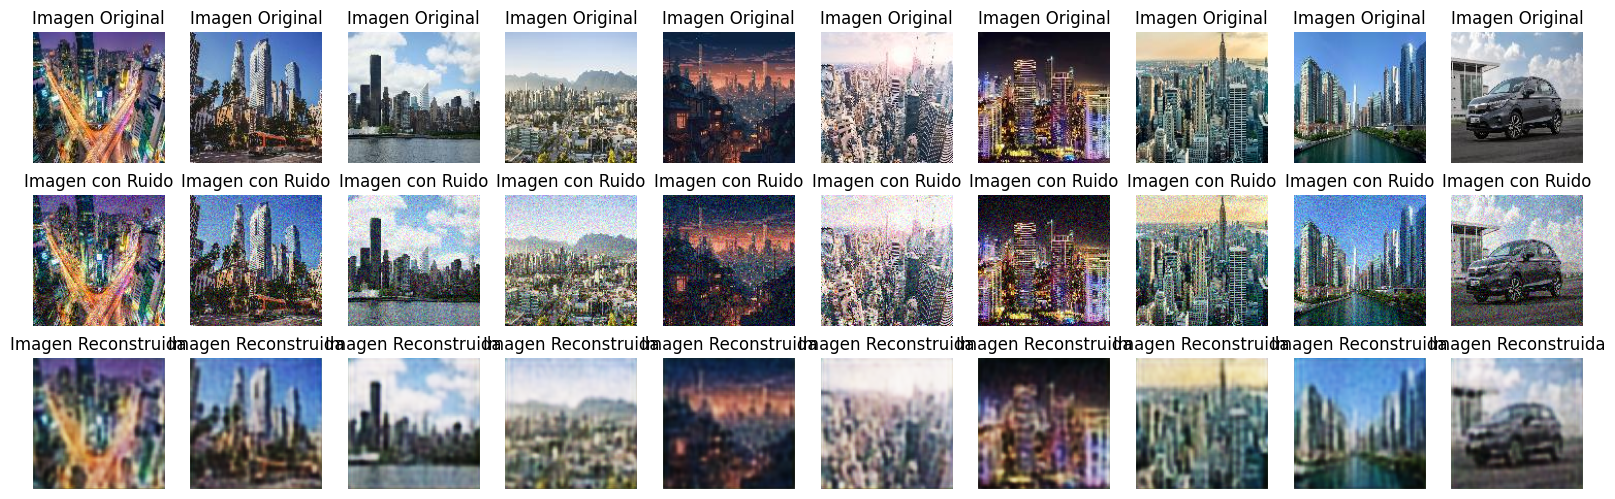

Train MSE: 0.015756931985111695
Train PSNR: 18.025283396158272 dB


/tmp/ipykernel_3259/3373842819.py:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(X_train, decoded_imgs)


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Comparar Imágenes
decoded_imgs = autoencoder.predict(X_train_noisy)

n = 10
plt.figure(figsize=(20, 6))  # Adjust the figure size to accommodate three rows

for i in range(n):
    # Imagen Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_train[i])
    plt.title("Imagen Original")
    plt.axis('off')

    # Imagen Original con Ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_train_noisy[i])
    plt.title("Imagen con Ruido")
    plt.axis('off')

    # Imagen Reconstruida
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Imagen Reconstruida")
    plt.axis('off')

plt.show()

# Mean Squared Error
mse = np.mean((X_train - decoded_imgs) ** 2)
print(f"Train MSE: {mse}")

# Peak Signal-to-Noise Ratio
psnr_value = psnr(X_train, decoded_imgs)
print(f"Train PSNR: {psnr_value} dB")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


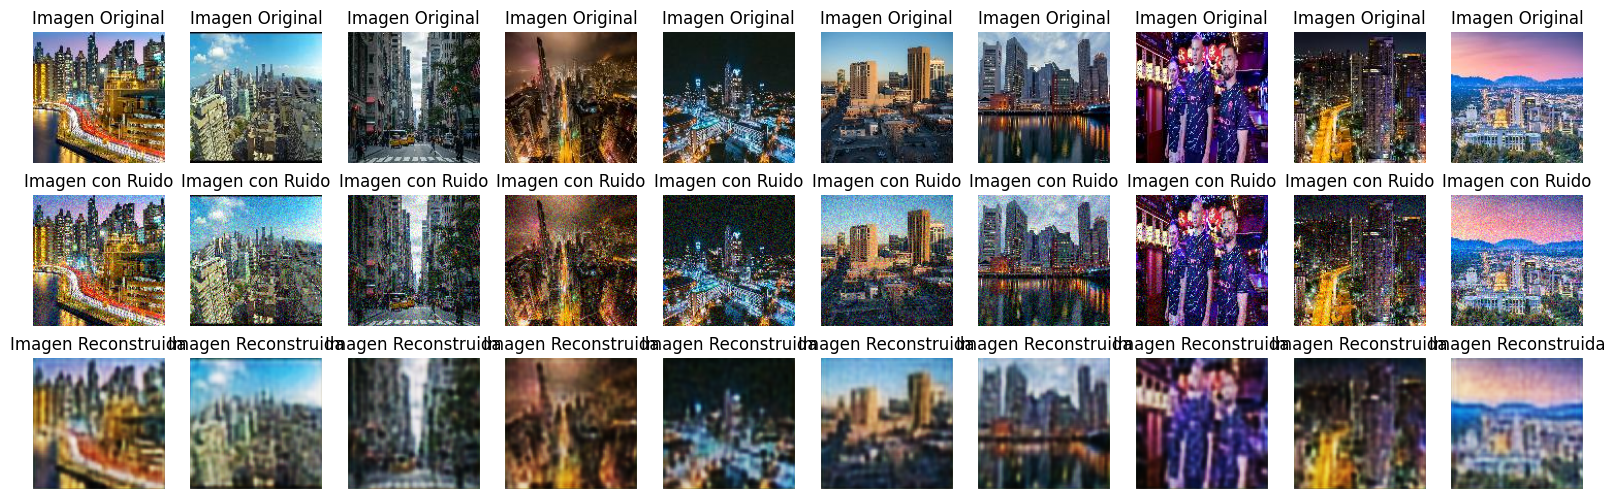

Train MSE: 0.0159592936963758
Train PSNR: 17.969863329448227 dB


/tmp/ipykernel_3259/3502570458.py:46: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_value = psnr(X_test, decoded_imgs)


In [ ]:
# Prueba con Imágenes Nuevas
city_test_path = "processed_dataset/city/test-city"
forest_test_path = "processed_dataset/forest/test-forest"

city_test = load_images(city_test_path)
forest_test = load_images(forest_test_path)

X_test = np.concatenate([city_test, forest_test])
X_test_noisy = np.array([add_gaussian_noise(img) for img in X_test])

decoded_imgs = autoencoder.predict(X_test_noisy)
from skimage.metrics import peak_signal_noise_ratio as psnr

# Comparar Imágenes
decoded_imgs = autoencoder.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 6))  # Adjust the figure size to accommodate three rows

for i in range(n):
    # Imagen Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("Imagen Original")
    plt.axis('off')

    # Imagen Original con Ruido
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(X_test_noisy[i])
    plt.title("Imagen con Ruido")
    plt.axis('off')

    # Imagen Reconstruida
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i])
    plt.title("Imagen Reconstruida")
    plt.axis('off')

plt.show()

# Mean Squared Error
mse = np.mean((X_test - decoded_imgs) ** 2)
print(f"Train MSE: {mse}")

# Peak Signal-to-Noise Ratio
psnr_value = psnr(X_test, decoded_imgs)
print(f"Train PSNR: {psnr_value} dB")